# Preprocessing

In [147]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
%autoreload 2

In [149]:
import torch

In [150]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [180]:
connection = Connection()
# Get client
client = connection.get_client()

In [208]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [209]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [210]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W10... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


218

In [211]:
summarize_null(df_all_wells_preprocessed)

qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
well_code    0
dhp          0
dht          0
whp          0
wht          0
choke        0
dcp          0
well_id      0
wc_mpfm      0
time_idx     0
dtype: int64

In [212]:
df_all_wells_preprocessed["well_code"].unique()

array([0.])

In [213]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed, test_size=0.2)
len(df_train), len(df_val), len(df_test)

(142, 31, 45)

In [214]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.2199


In [215]:
model.score_physics(df_test)

{'W10': {'qo': {'r2': 0.3458394166436758,
   'mae': 21.033213678245634,
   'rmse': 26.164466589494186,
   'mre (%)': 19.780900563468627,
   'mpe (%)': 7.432947085663454},
  'qw': {'r2': 0.8405825543429367,
   'mae': 3.742721731496287,
   'rmse': 5.4508287423125426,
   'mre (%)': 61.877998127790065,
   'mpe (%)': -6.4789498156463035},
  'qg': {'r2': 0.6980460855053919,
   'mae': 1312.897370682334,
   'rmse': 1891.9364000940855,
   'mre (%)': 7.962874229548417,
   'mpe (%)': -2.009084257526371},
  'wgr': {'r2': 0.6958287382033779,
   'mae': 0.00031250144413594343,
   'rmse': 0.000562450376223826,
   'mre (%)': 70.85633641957605,
   'mpe (%)': 1.6213282141665717},
  'gor': {'r2': -0.16662913747174435,
   'mae': 14.636146586526209,
   'rmse': 20.230981623429525,
   'mre (%)': 10.932233359762424,
   'mpe (%)': -5.669733146436752}}}

In [216]:
model.score_hybrid(df_test)

{'W10': {'qo': {'r2': 0.797893339572403,
   'mae': 11.299752502432083,
   'rmse': 14.543201191893385,
   'mre (%)': 10.466291292521927,
   'mpe (%)': -5.686235434783759},
  'qw': {'r2': 0.9417207710106456,
   'mae': 2.8083552237985634,
   'rmse': 3.2957291482016737,
   'mre (%)': 62.303705954367736,
   'mpe (%)': -33.09474887716737},
  'qg': {'r2': 0.9220118598257674,
   'mae': 743.6388916609457,
   'rmse': 961.5026436734597,
   'mre (%)': 5.192808325041177,
   'mpe (%)': 0.9572046746898523},
  'wgr': {'r2': 0.8908187427337572,
   'mae': 0.00024346079540377985,
   'rmse': 0.0003369761526089036,
   'mre (%)': 63.740421349459794,
   'mpe (%)': -32.802632292494216},
  'gor': {'r2': -0.5417933976438016,
   'mae': 15.79112332829631,
   'rmse': 23.257532518198783,
   'mre (%)': 12.619866713197418,
   'mpe (%)': 9.014033078540324}}}

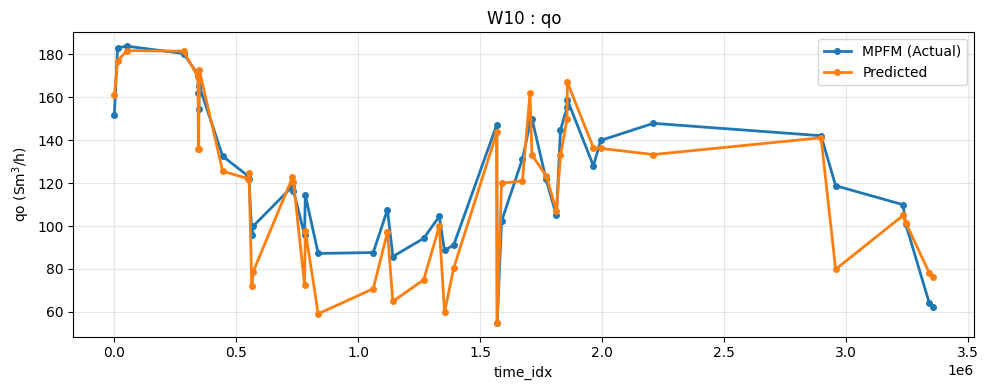

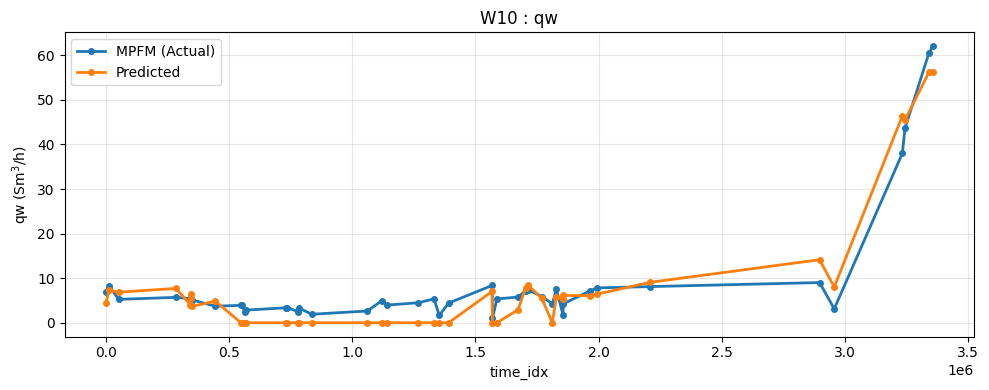

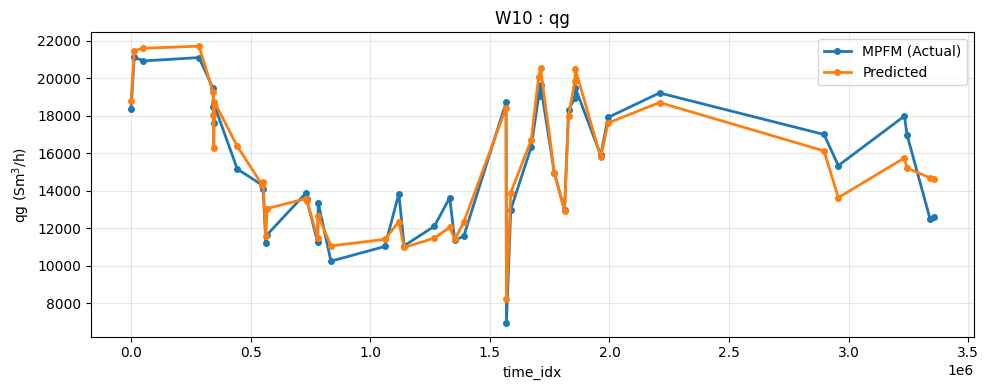

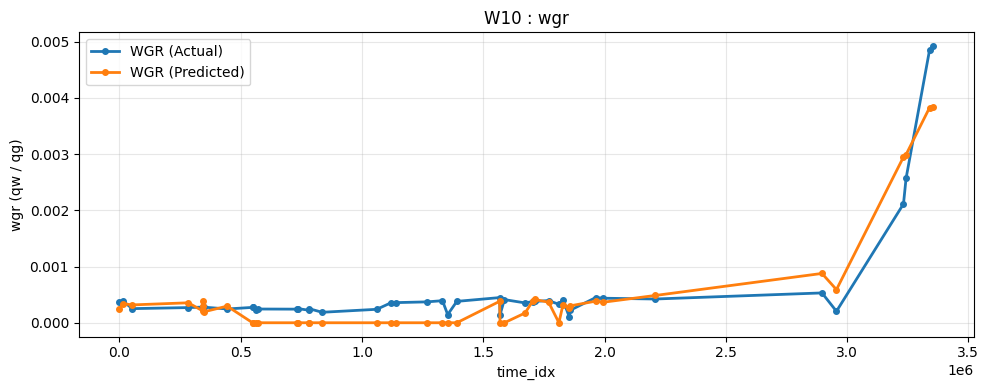

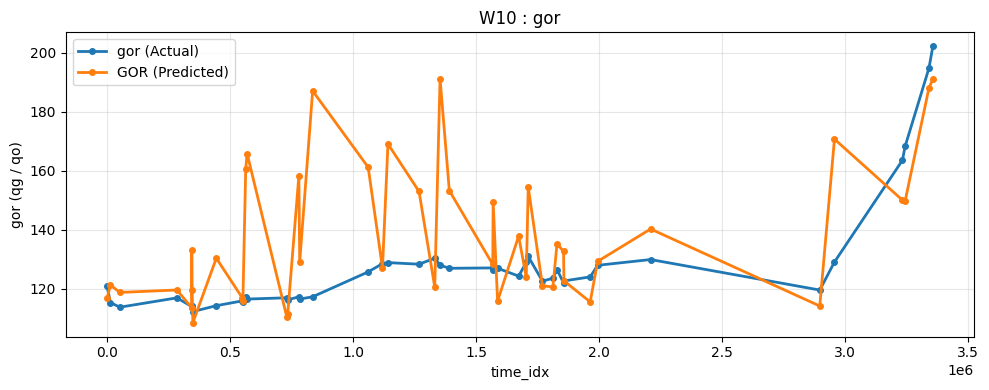

In [217]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [218]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [219]:
# lowo_with_partial_calibration(df=df_with_targets)